In [10]:
import time as ti
import gzip as gz
import numpy as np
import pandas as pd
import pickle as pk
import requests as rq
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy import sparse
from tifffile import TiffFile

In [2]:
%run ../src/geo_helpers.py

In [6]:
earthquakes_res = rq.get('https://earthquake.usgs.gov/fdsnws/event/1/query.geojson?starttime=1992-01-01%2000:00:00&endtime=1999-12-31%2000:00:00&minmagnitude=5&orderby=time')
earthquakes = earthquakes_res.json()['features']

In [14]:
%%time
for npz_path in npz_paths:
    lum_raster = sparse.lil_matrix(np.load(npz_path)['arr_0'])
    qks_raster = sparse.lil_matrix(lum_raster.shape)
    for earthquake in earthquakes:
        if ti.gmtime(earthquake['properties']['time']/1000).tm_year == 1992:
            coo = *earthquake['geometry']['coordinates'],
            pxl = as_pixels(target_coords={'lat':coo[1],'lng':coo[0]})
            try:
                qks_raster[pxl[0],pxl[1]] = earthquake['properties']['mag']
            except IndexError:
                print(earthquake['properties']['title'])
                pass
            
    np.savez_compressed(npz_path.replace('raw','interim'),{
        'lum': lum_raster, 'qks': qks_raster
    })

M 5.6 - Balleny Islands region
CPU times: user 14.3 s, sys: 1.97 s, total: 16.3 s
Wall time: 17.2 s


In [43]:
%run ../src/geo_helpers.py

In [51]:
df_quakes = pd.DataFrame([
    (
        q['geometry']['coordinates'][1],
        q['geometry']['coordinates'][0],
        q['properties']['mag'],
        ti.gmtime(q['properties']['time']/1000).tm_year
    ) for q in earthquakes
], columns=['lat','lng','mag','year'])

In [67]:
df_quakes[df_quakes['year']==1993].sort_values('mag').head(25)

,lat,lng,mag,year
9130,-11.931,119.281,5.0,1993
9135,53.831,160.514,5.0,1993
8316,-5.806,146.246,5.0,1993
8315,-5.795,146.195,5.0,1993
9136,-13.437,66.718,5.0,1993
8312,-6.727,129.862,5.0,1993
9139,-9.276,113.246,5.0,1993
9141,-34.246,-178.725,5.0,1993
9147,32.981,96.053,5.0,1993
8483,-22.078,-179.297,5.0,1993


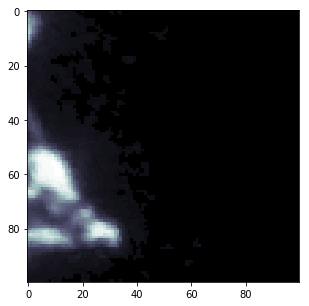

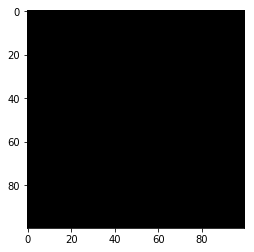

In [75]:
location = as_pixels(target_coords={'lat': 36,'lng': 141})
plt.figure(figsize=(10,5))
d=50
image = lum_raster[(location[0]-d):(location[0]+d), (location[1]-d):(location[1]+d)].toarray()
quakes = qks_raster[(location[0]-d):(location[0]+d), (location[1]-d):(location[1]+d)].toarray()
plt.imshow(image,
           cmap='bone')
plt.show()
plt.imshow(quakes, cmap='afmhot')
plt.show()